# Start Session

In [117]:
# this has to be run on the cluster version 
# sc.install_pypi_package("pandas")
# sc.install_pypi_package("matplotlib")
# to make a plot need to use
# %matplot plt

In [119]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql import types as t
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import Imputer, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from datetime import datetime as dt
from pyspark.sql import types as T
import pandas as pd

In [120]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("sparkify") \
    .getOrCreate()

# Load Data
Here the entire set of 26 million rows is loaded. 

In [121]:
# full dataset
# event_data = 's3n://udacity-dsnd/sparkify/sparkify_event_data.json'
# mini dataset
# event_data = s3n://udacity-dsnd/sparkify/mini_sparkify_event_data.json
# udacity workspace
event_data = "mini_sparkify_event_data.json"

In [122]:
df = spark.read.json(event_data)

In [123]:
df_pd = df.limit(10).toPandas()

df_pd.head(10)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
5,The All-American Rejects,Logged In,Micah,M,81,Long,208.29995,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Don't Leave Me,200,1538352678000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
6,The Velvet Underground / Nico,Logged In,Micah,M,82,Long,260.46649,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Run Run Run,200,1538352886000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
7,Starflyer 59,Logged In,Colin,M,53,Freeman,185.44281,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Passengers (Old Album Version),200,1538352899000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
8,None,Logged In,Colin,M,54,Freeman,NaN,paid,"Bakersfield, CA",PUT,Add to Playlist,1538173362000,29,None,200,1538352905000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
9,Frumpies,Logged In,Colin,M,55,Freeman,134.47791,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Fuck Kitty,200,1538353084000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [124]:
# the size of the dataset
df = df.filter(df.auth != "Guest")
print((df.count(), len(df.columns)))

(286403, 18)


### How Many Nulls? 

In [125]:
# show percent nulls
# because 'artist','length','song' have so many missing values I will not use them
df.select(
    [
        ( (F.count(F.when(F.isnull(c), c)) / F.count(c)) * 100 ) \
            .alias(c) for c in df.columns
    ]
).show(vertical=True)

-RECORD 0--------------------------
 artist        | 25.55587704070002 
 auth          | 0.0               
 firstName     | 2.965623359721593 
 gender        | 2.965623359721593 
 itemInSession | 0.0               
 lastName      | 2.965623359721593 
 length        | 25.55587704070002 
 level         | 0.0               
 location      | 2.965623359721593 
 method        | 0.0               
 page          | 0.0               
 registration  | 2.965623359721593 
 sessionId     | 0.0               
 song          | 25.55587704070002 
 status        | 0.0               
 ts            | 0.0               
 userAgent     | 2.965623359721593 
 userId        | 0.0               



### Define Churn
`Churn` is defined as when the app registers the `Cancellation Confirmation` page. This occurs for both free and paid users. 

In [126]:
# this is a binary, indicator column to be used to predict churn
df = df.withColumn(
    'churn',
    F.when((F.col('page') =='Cancellation Confirmation'), 1) \
    .otherwise(0)
)

# Explore Ratios of Churn

In [127]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- churn: integer (nullable = false)



In [128]:
# create udf
get_month = F.udf(lambda month: dt.fromtimestamp( month / 1000.0 ).strftime("%m") if month is not None else None)
# 
df = df.withColumn("registrationMonth", get_month("registration").cast(T.IntegerType())) \
    .withColumn("tsMonth", get_month("ts").cast(T.IntegerType())) \
    .withColumn("diffMonth", F.col("tsMonth") - F.col("registrationMonth"))

In [38]:
cancel_rate_by_month = df.select("diffMonth","churn", "userId") \
    .filter(df.diffMonth > 0) \
    .filter(df.diffMonth < 6) \
    .dropDuplicates() \
    .groupBy("diffMonth") \
    .pivot("churn") \
    .agg(F.countDistinct("userId").alias("userIdCount")) \
    .orderBy("diffMonth") \
    .withColumn("percent", ( F.col("1") / ( F.col("1") + F.col("0") ) ) * 100 ) \
    .select("diffMonth", "percent") \
    .toPandas()

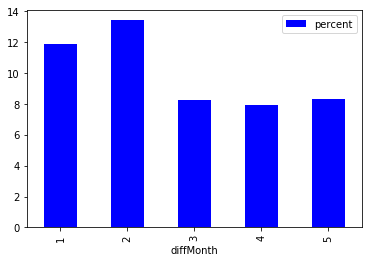

In [42]:
%matplotlib inline
cancel_rate_by_month.plot(kind='bar',x='diffMonth',y='percent', color='blue')

In [22]:
# users who have a cancellation value of 1
users_who_quit = df.filter(df.churn==1) \
    .select(df.userId) \
    .dropDuplicates()

# users who have a cancellation value of 0
users_who_stayed = df.filter(df.churn==0) \
    .select(df.userId) \
    .dropDuplicates()

# examine their lengths
users_who_quit.count(), users_who_stayed.count(), ( users_who_quit.count() / (users_who_quit.count() + users_who_stayed.count())) * 100

(52, 226, 18.705035971223023)

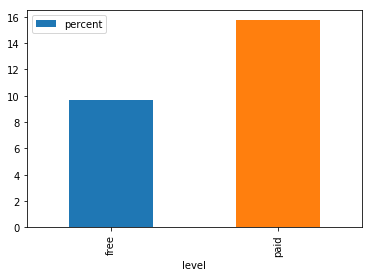

In [57]:
# are cancellation rates the same between free and paid users? 
churn_table = df.select("level","churn","userId") \
    .dropDuplicates() \
    .groupBy("level") \
    .pivot("churn") \
    .agg(F.count("userId").alias("userIdCount")) \
    .withColumn("percent", (F.col("1")/(F.col("1") + F.col("0")))*100) \
    .toPandas() 

churn_table.plot(kind='bar',x='level',y='percent')

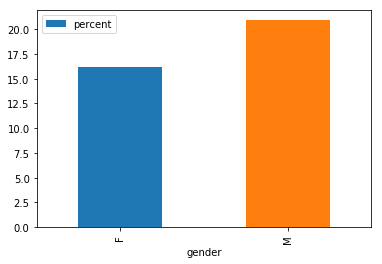

In [61]:
# are cancellation rates the same between genders? 
churn_table = df.select("gender","churn","userId") \
    .filter(~F.isnull("gender")) \
    .dropDuplicates() \
    .groupBy("gender") \
    .pivot("churn") \
    .agg(F.count("userId").alias("userIdCount")) \
    .withColumn("percent", (F.col("1")/(F.col("1") + F.col("0"))) * 100) \
    .toPandas()

churn_table.plot(kind='bar',x='gender',y='percent')

# Feature Engineering
The goal is to predict behavior at the user level--specifically if the user 'churns' or not. Therefore, my feature engineering focuses on finding characteristics at the `user` level. For each feature, I create a dataframe with the `userId` as the key. The dataframes are joined together, ensuring that one row eqauls one unique `userId`. Finally, the `userId` column is dropped. 

Ideas for features are: 
1. Cumulative Totals Per User: 
    - Add Friends
    - Add to Playlist
    - Roll Advertisement
    - Error
    - Login / Logout
    - Thumbs Up / Thumbs Down
    - Submit Upgrade / Submit Downgrade

2. Location: 
    - City
    - State
    
3. userAgent: 
    - browser
    - os 
    - brand
    
4. Time: 
    - Avg. Length of Session
    - Time Spent as Free / Paid Level
    - Time User spent on Sparkify
    
5. Gender of User

### 1. Cumulative Totals DataFrame

In [129]:
# Cumulative Totals of Page Per User
page_list = ["Add Friend", "Add to Playlist", "Logout", "Thumbs Up", 
             "Thumbs Down", "Error", "Roll Advert", "Help"]

user_page = df.select("userId","page") \
    .filter(F.col("page").isin(page_list)) \
    .groupBy("userId") \
    .pivot("page") \
    .agg(F.count("page").alias("page_count"))

user_page.show()

+------+----------+---------------+-----+----+------+-----------+-----------+---------+
|userId|Add Friend|Add to Playlist|Error|Help|Logout|Roll Advert|Thumbs Down|Thumbs Up|
+------+----------+---------------+-----+----+------+-----------+-----------+---------+
|200002|         4|              8| null|   2|     5|          7|          6|       21|
|100010|         4|              7| null|   2|     5|         52|          5|       17|
|   125|      null|           null| null|null|  null|          1|       null|     null|
|    51|        28|             52|    1|  12|    24|       null|         21|      100|
|     7|         1|              5|    1|   1|     3|         16|          1|        7|
|   124|        74|            118|    6|  23|    59|          4|         41|      171|
|    54|        33|             72|    1|  17|    36|         47|         29|      163|
|    15|        31|             59|    2|   8|    27|          1|         14|       81|
|   155|        11|             

### 2. Location DataFrame

In [130]:
# split the 'location' field into 'city' and 'state fields'
user_location = df.withColumn('city', F.split(df['location'], ',').getItem(0)) \
    .withColumn('state', F.split(df['location'], ',').getItem(1)) \
    .select("userId","city","state") \
    .dropDuplicates()

user_location.show()

+------+--------------------+------------+
|userId|                city|       state|
+------+--------------------+------------+
|    13|Philadelphia-Camd...| PA-NJ-DE-MD|
|   124|  Vineland-Bridgeton|          NJ|
|300017|               Ionia|          MI|
|    67|Sacramento--Rosev...|          CA|
|    91|   New Haven-Milford|          CT|
|   136|Charlotte-Concord...|       NC-SC|
|200021|Detroit-Warren-De...|          MI|
|300005|             Roanoke|          VA|
|    20|Miami-Fort Lauder...|          FL|
|   151|Washington-Arling...| DC-VA-MD-WV|
|    95|Phoenix-Mesa-Scot...|          AZ|
|   104|            Billings|          MT|
|300008|          Cookeville|          TN|
|    62|Houston-The Woodl...|          TX|
|300009|           St. Louis|       MO-IL|
|    24|                Troy|          AL|
|    81|Philadelphia-Camd...| PA-NJ-DE-MD|
|    93|Allentown-Bethleh...|       PA-NJ|
|   114|Las Vegas-Henders...|          NV|
|    99|   New Haven-Milford|          CT|
+------+---

### 3. Browser/Device DataFrame

In [131]:
# create browser, os, brand from userAgent
df = df.withColumn('browser', F.split(df['userAgent'], '\(').getItem(0)) \
    .withColumn('temp', F.split(df['userAgent'], '\(').getItem(1)) 

df = df.withColumn('os', F.split(df['temp'], ';').getItem(0)) \
    .withColumn('brand', F.split(df['temp'], ';').getItem(1))

user_browser = df.select("userId","browser","os","brand").dropDuplicates()

user_browser.show()

+------+-------------+--------------------+--------------------+
|userId|      browser|                  os|               brand|
+------+-------------+--------------------+--------------------+
|    74|"Mozilla/5.0 |           Macintosh| Intel Mac OS X 1...|
|    14| Mozilla/5.0 |           Macintosh| Intel Mac OS X 10.9|
|100010|"Mozilla/5.0 |              iPhone| CPU iPhone OS 7_...|
|    59| Mozilla/5.0 |      Windows NT 6.1|               WOW64|
|   132|"Mozilla/5.0 |           Macintosh| Intel Mac OS X 1...|
|   153|"Mozilla/5.0 |      Windows NT 6.1| WOW64) AppleWebK...|
|    83|"Mozilla/5.0 |                 X11| Linux x86_64) Ap...|
|100014|"Mozilla/5.0 |      Windows NT 6.1| WOW64) AppleWebK...|
|    96|"Mozilla/5.0 |           Macintosh| Intel Mac OS X 1...|
|200023|"Mozilla/5.0 |      Windows NT 6.3| WOW64) AppleWebK...|
|200006|"Mozilla/5.0 |           Macintosh| Intel Mac OS X 1...|
|    28| Mozilla/5.0 |      Windows NT 6.1|               WOW64|
|    70|"Mozilla/5.0 |   

### 4. Time DataFrames

In [132]:
# create window partition
w = Window.partitionBy("userId","sessionId").orderBy("sessionId")
# calculate session duration ( per user ) in HOURS
user_sess_dur = df.select("userId","sessionId","ts") \
    .withColumn("max_ts", F.max('ts').over(w)) \
    .withColumn("min_ts", F.min('ts').over(w)) \
    .withColumn("tsDiff", ( F.col('max_ts') - F.col('min_ts')) / ( 1000 * 3600 )) \
    .select("userId","sessionId","tsDiff") \
    .dropDuplicates() \
    .groupBy("userId") \
    .agg(F.round(F.avg("tsDiff"),1).alias("avgSessionHours"))

user_sess_dur.show()

+------+---------------+
|userId|avgSessionHours|
+------+---------------+
|100010|            2.6|
|200002|            4.4|
|   125|            0.5|
|    51|           14.5|
|   124|            9.6|
|     7|            1.5|
|    54|            5.4|
|    15|            8.8|
|   155|            9.1|
|100014|            3.1|
|   132|            8.3|
|   154|            1.8|
|   101|           13.6|
|    11|            2.7|
|300017|            3.9|
|   138|            9.4|
|    29|            6.1|
|    69|            8.8|
|100021|            3.6|
|    42|            5.5|
+------+---------------+
only showing top 20 rows



In [133]:
# create window partition
w = Window.partitionBy("userId").orderBy("userId")
# calculate total time used
user_days = df.select("userId","ts") \
    .withColumn("max_ts", F.max('ts').over(w)) \
    .withColumn("min_ts", F.min('ts').over(w)) \
    .withColumn("daysUsed", F.round(( F.col('max_ts') - F.col('min_ts') ) / ( 1000 * 3600 * 24), 1)) \
    .select("userId", "daysUsed") \
    .dropDuplicates()

user_days.show()

+------+--------+
|userId|daysUsed|
+------+--------+
|100010|    44.2|
|200002|    45.5|
|   125|     0.0|
|   124|    60.0|
|    51|    15.8|
|     7|    50.8|
|    15|    54.8|
|    54|    42.8|
|   155|    25.8|
|100014|    41.2|
|   132|    50.5|
|   154|    25.0|
|   101|    15.9|
|    11|    53.2|
|   138|    56.1|
|300017|    59.1|
|100021|    45.5|
|    29|    43.3|
|    69|    51.0|
|   112|    56.9|
+------+--------+
only showing top 20 rows



In [134]:
# create window partition
w = Window.partitionBy("userId", "level").orderBy("userId")

user_level = df.select("userId", "level", "ts") \
    .withColumn("max_ts", F.max("ts").over(w)) \
    .withColumn("min_ts", F.min("ts").over(w)) \
    .withColumn("daysAs", (F.col("max_ts") - F.col("min_ts")) / (1000 * 3600 * 24)) \
    .select("userId","level","daysAs") \
    .dropDuplicates() \
    .groupBy("userId") \
    .pivot("level") \
    .agg(F.round(F.avg("daysAs"),1))

user_level.show()

+------+----+----+
|userId|free|paid|
+------+----+----+
|200002|16.9|28.6|
|100010|44.2|null|
|   125| 0.0|null|
|     7|50.8|null|
|   124|null|60.0|
|    51|null|15.8|
|    54|14.0|42.8|
|    15|null|54.8|
|   155| 6.4|19.4|
|   132| 0.1|50.4|
|   154|25.0|null|
|100014|null|41.2|
|    11|42.5|47.1|
|   101| 1.7|14.2|
|300017|null|59.1|
|   138|16.6|39.5|
|100021|45.5|null|
|    29| 6.7|36.6|
|    69| 4.1|46.9|
|   112|56.9|null|
+------+----+----+
only showing top 20 rows



### 5. Gender and Registration Month DataFrame

In [135]:
user_gender = df.select("userId", "gender","registrationMonth") \
    .dropDuplicates()

user_gender.show()

+------+------+-----------------+
|userId|gender|registrationMonth|
+------+------+-----------------+
|    51|     M|                9|
|   137|     M|                7|
|   149|     M|                9|
|200006|     F|                9|
|200004|     M|                9|
|300001|     F|                5|
|     4|     M|                9|
|    95|     F|                9|
|   148|     M|                9|
|300006|     M|                8|
|100018|     M|                8|
|200020|     M|                9|
|   101|     M|                8|
|   108|     F|                9|
|100023|     M|                9|
|   113|     F|                7|
|300005|     F|                6|
|    66|     F|                7|
|   133|     M|                9|
|200022|     M|                8|
+------+------+-----------------+
only showing top 20 rows



### 6. Churn DataFrame

In [136]:
# create churn table
user_churn = df.select("userId", "churn") \
    .groupBy("userId") \
    .agg(F.sum("churn").alias("label"))

user_churn.show()

+------+-----+
|userId|label|
+------+-----+
|100010|    0|
|200002|    0|
|   125|    1|
|    51|    1|
|   124|    0|
|     7|    0|
|    54|    1|
|    15|    0|
|   155|    0|
|   132|    0|
|   154|    0|
|100014|    1|
|   101|    1|
|    11|    0|
|   138|    0|
|300017|    0|
|    29|    1|
|    69|    0|
|100021|    1|
|    42|    0|
+------+-----+
only showing top 20 rows



### Join DataFrames

In [137]:
# 'user_location' and 'user_days' are not used. 
# 'user_location' does not describe user behavior
# 'user_days' is the sum of 'free' and 'paid' in 'user_level' so could be a confounder
# join all the tables together
user_data = user_churn.join(user_page, ['userId'], "left") \
    .join(user_browser,['userId'], "left") \
    .join(user_sess_dur, ['userId'], "left") \
    .join(user_level, ['userId'], "left") \
    .join(user_gender, ['userId'], "left") \
    .drop("userId")

user_data.show(1, vertical=True)

-RECORD 0---------------------------------
 label             | 0                    
 Add Friend        | 4                    
 Add to Playlist   | 7                    
 Error             | null                 
 Help              | 2                    
 Logout            | 5                    
 Roll Advert       | 52                   
 Thumbs Down       | 5                    
 Thumbs Up         | 17                   
 browser           | "Mozilla/5.0         
 os                | iPhone               
 brand             |  CPU iPhone OS 7_... 
 avgSessionHours   | 2.6                  
 free              | 44.2                 
 paid              | null                 
 gender            | F                    
 registrationMonth | 9                    
only showing top 1 row



In [138]:
# final size of dataset
print((user_data.count(), len(user_data.columns)))

(226, 17)


### Replace Nulls

In [139]:
# define list of numeric columns
numeric_cols = user_page.columns[1:] + user_sess_dur.columns[1:] + user_level.columns[1:] + ['registrationMonth']
# create dictionary specifying that 0 will be used to fill missing rows
impute_numeric = { i : 0 for i in numeric_cols }
# fill missing rows in numeric columns
user_data = user_data.fillna(impute_numeric)
# define list of category columns (strings)
categ_cols = user_browser.columns[1:] + ['gender']
# create dictionary specifying that 'missing' will be used to fill missing rows
impute_categ = { i : 'missing' for i in categ_cols }
# fill missing rows in category columns
user_data = user_data.fillna(impute_categ)
# show % nulls - should be 0 for every column
user_data.select(
    [
        ( (F.count(F.when(F.isnull(c), c)) / F.count(c)) * 100 ) \
            .alias(c) for c in user_data.columns
    ]
).show(vertical=True)

-RECORD 0----------------
 label             | 0.0 
 Add Friend        | 0.0 
 Add to Playlist   | 0.0 
 Error             | 0.0 
 Help              | 0.0 
 Logout            | 0.0 
 Roll Advert       | 0.0 
 Thumbs Down       | 0.0 
 Thumbs Up         | 0.0 
 browser           | 0.0 
 os                | 0.0 
 brand             | 0.0 
 avgSessionHours   | 0.0 
 free              | 0.0 
 paid              | 0.0 
 gender            | 0.0 
 registrationMonth | 0.0 



# Modeling

### Split into Training / Testing Sets

In [140]:
training, testing = user_data.randomSplit([0.8, 0.2], seed=100)

### Create Pipeline

In [99]:
# create list of category output columns from previously defined categ_columns
o_categ_cols = [ n + 'Index' for n in categ_cols ] 
# encode categories in pipeline
categ_pipeline = Pipeline(stages=[
    StringIndexer(inputCols=categ_cols, outputCols=o_categ_cols, handleInvalid='skip'),
    VectorAssembler(
        inputCols=o_categ_cols, 
        outputCol="categ_features"
    )
])

TypeError: __init__() got an unexpected keyword argument 'inputCols'

In [141]:
# numeric pipeline - use numeric columns defined earlier
numer_pipeline = Pipeline(stages=[
    VectorAssembler(inputCols=numeric_cols, outputCol="numer_features")
])

In [30]:
# unite pipelines ( final features have to be named 'features')
# unite pipelines
final_pipeline = Pipeline(stages=[
    categ_pipeline,
    numer_pipeline,
    VectorAssembler(
        inputCols=["categ_features","numer_features"],
        outputCol="features"
    ),
    LogisticRegression(maxIter=10)
])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Cross-Validate on Training Set

In [31]:
# define parameters ( just one )
paramGrid = ParamGridBuilder() \
    .addGrid(LogisticRegression.regParam, [0.1, 0.05, 0.01]) \
    .build()

# optimize 4 fold cross-validation using the area under ROC curve
crossval = CrossValidator(estimator=final_pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol='label',metricName='areaUnderROC'),
                          numFolds=3) 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [32]:
cvModel = crossval.fit(training)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [33]:
# certainly looks like the regParam is fine at 0.1
cvModel.avgMetrics

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[0.7769540579729164, 0.7769540579729164, 0.7769540579729164]

### Fit Tuned Pipeline on Entire Training Set

In [103]:
# unite pipelines ( final features have to be named 'features')
# unite pipelines
final_pipeline2 = Pipeline(stages=[
    #categ_pipeline,
    numer_pipeline,
    VectorAssembler(
        # inputCols=["categ_features","numer_features"],
        inputCols=["numer_features"],
        outputCol="features"
    ),
    LogisticRegression(maxIter=10, regParam=0.1)
])

pipelineModel = final_pipeline2.fit(training)

In [104]:
# show accuracy and AUC
summaryPipeline = pipelineModel.stages[-1].summary
summaryPipeline.accuracy, summaryPipeline.areaUnderROC

(0.7754010695187166, 0.8576354679802947)

### Calculate Odds-Ratios

In [106]:
numeric_cols

['Add Friend',
 'Add to Playlist',
 'Error',
 'Help',
 'Logout',
 'Roll Advert',
 'Thumbs Down',
 'Thumbs Up',
 'avgSessionHours',
 'free',
 'paid',
 'registrationMonth']

In [107]:
import numpy as np

coeffs = pipelineModel.stages[-1].coefficientMatrix
odds_ratios = np.around(np.exp(coeffs.toArray()),2).tolist()
# feature_list = o_categ_cols + numeric_cols
feature_list = numeric_cols
odds_ratios_df = spark.createDataFrame(
    [ t for t in zip(odds_ratios[0], feature_list)],
    ["or", "feature"]
)

odds_ratios_df.show(30)

+----+-----------------+
|  or|          feature|
+----+-----------------+
|0.99|       Add Friend|
| 1.0|  Add to Playlist|
| 0.9|            Error|
| 1.0|             Help|
| 1.0|           Logout|
|1.01|      Roll Advert|
|1.01|      Thumbs Down|
| 1.0|        Thumbs Up|
| 1.0|  avgSessionHours|
|0.97|             free|
|0.98|             paid|
|1.08|registrationMonth|
+----+-----------------+



### Score on Testing Set

In [108]:
# generate predictions
predictions = pipelineModel.transform(testing)
# intialize the evaluator
bce = BinaryClassificationEvaluator(labelCol='label', metricName='areaUnderROC').evaluate(predictions)

In [109]:
# area-under-receiver-operating-characteristic-curve of testing set
bce

0.8620689655172413

# Model with Ensemble

In [110]:
from pyspark.ml.classification import GBTClassifier

In [142]:
# unite pipelines ( final features have to be named 'features')
# unite pipelines
final_pipeline2 = Pipeline(stages=[
    #categ_pipeline,
    numer_pipeline,
    VectorAssembler(
        # inputCols=["categ_features","numer_features"],
        inputCols=["numer_features"],
        outputCol="features"
    ),
    GBTClassifier(maxIter=10)
])

# pipelineModel = final_pipeline2.fit(training)

In [143]:
# define parameters ( just one )
paramGrid = ParamGridBuilder() \
    .addGrid(GBTClassifier.maxDepth, [3, 5]) \
    .addGrid(GBTClassifier.maxBins, [25, 36]) \
    .build()

# optimize 4 fold cross-validation using the area under ROC curve
crossval = CrossValidator(estimator=final_pipeline2,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol='label',metricName='areaUnderROC'),
                          numFolds=3) 

In [144]:
cvModel = crossval.fit(training)

In [145]:
cvModel.avgMetrics

[0.797242212487832, 0.797242212487832, 0.797242212487832, 0.797242212487832]

# And again on full

In [168]:
# unite pipelines ( final features have to be named 'features')
# unite pipelines
final_pipeline2 = Pipeline(stages=[
    #categ_pipeline,
    numer_pipeline,
    VectorAssembler(
        # inputCols=["categ_features","numer_features"],
        inputCols=["numer_features"],
        outputCol="features"
    ),
    GBTClassifier()
])

pipelineModel = final_pipeline2.fit(training)

In [169]:
fi = [pipelineModel.stages[-1].featureImportances[n] for n in list(range(0,12))]
[ t for t in zip(fi, numeric_cols)]

[(0.088702360166918459, 'Add Friend'),
 (0.054165918938549364, 'Add to Playlist'),
 (0.011908185963478701, 'Error'),
 (0.019533266866470961, 'Help'),
 (0.057597619060936654, 'Logout'),
 (0.12903683493836027, 'Roll Advert'),
 (0.14117229230872444, 'Thumbs Down'),
 (0.029391583652030779, 'Thumbs Up'),
 (0.082393930627845835, 'avgSessionHours'),
 (0.16766440269160818, 'free'),
 (0.097531839174992141, 'paid'),
 (0.12090176561008406, 'registrationMonth')]

In [170]:
# generate predictions
predictions = pipelineModel.transform(testing)
# intialize the evaluator
bce = BinaryClassificationEvaluator(labelCol='label', metricName='areaUnderROC').evaluate(predictions)

In [171]:
# area-under-receiver-operating-characteristic-curve of testing set
bce

0.8344827586206895

# Results and Conclusion

Splitting the user data into training and testing sets (60% and 40%, respectively) was sufficient. The final AUC was: 
* 0.76 for the training set 
* 0.75 for the testing set

which is close enough together to suggest that under-fitting, and not over-fitting, was a possible issue. 

The odds-ratios showed that some features ( regarding user behavior ) were associated with an increased probability of 'churn' while others were associated with a _decreased_ probability of churn. Specifically: 

A _one_ unit increase of: 
* the number of advertisements
* the number of 'thumbs down' 
* the average number of hours a session lasted

_increased_ the probability of 'churning' by 1%

whereas a _one_ unit increase of: 
* browser
* os
* gender
* days as a 'paid' user

_decreased_ the probability of 'churning' by 1%. In the case of the 'category' column type, the 'one unit increase' is really the act of moving from the base class to the next class. For example, moving from _Female_ (the base class) to _Male_ decreased the probability of 'churning.' This seems to indicate that _Females_ were more likely to 'churn.' 

Finally, a _one_ unit increase of: 
* days spent at the 'free' level

_decreased_ the probability of 'churning' by _2%_

The recommendation based on these findings is that Sparkify should investigate ways to: 
* keep the female audience engaged
* encourage users to login everyday
* limit the number of advertisements a user has to watch
* decrease the number of 'thumbs down' that a user feels compelled to give

Sparkify should also investigate if there are issues with the service via a particular Internet Browser or OS. 

Realistically, these recommendations have no weight until the accuracy / AUC can be increased. Thank you for reading!